In [ ]:
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple nubra-sdk

In [3]:
# IMPORTS

import time
import json
import threading
import json
import time
import csv
import os
from nubra_python_sdk.start_sdk import InitNubraSdk, NubraEnv
from nubra_python_sdk.ticker import websocketdata
from auth import authenticate_nubra
from nubra_python_sdk.marketdata.market_data import MarketData
from nubra_python_sdk.refdata.instruments import InstrumentData
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def fetch_instrument_ref_ids(nubra_sdk, nubra_names):
    market_data = MarketData(nubra_sdk)
    instruments = InstrumentData(nubra_sdk)

    ref_ids = []

    for name in nubra_names:
        instrument = instruments.get_instrument_by_nubra_name(name)
        ref_ids.append(instrument.ref_id)

    return ref_ids

def generate_nifty_option_nubra_names():
    expiry = "20260106"
    start_strike = 2050000
    end_strike = 3145000
    step = 5000

    nubra_names = []

    strike = start_strike
    while strike <= end_strike:
        nubra_names.append(f"OPT_NIFTY_{expiry}_CE_{strike}")
        nubra_names.append(f"OPT_NIFTY_{expiry}_PE_{strike}")
        strike += step

    return nubra_names

In [7]:
# PARAMETERS (FIXED FOR NOW)

TICK_SIZE = 5
S0 = 2 * TICK_SIZE          # static spread
ALPHA = 0.3
K = 0.1
QMAX = 10

In [9]:
# GLOBAL SHARED STATE

latest_orderbooks = {}
orderbook_lock = threading.Lock()

ws_stop_event = threading.Event()
ws_thread = None
market_socket = None

json_logger_stop_event = threading.Event()
json_logger_thread = None

trading_stop_event = threading.Event()
trading_thread = None

In [11]:
# WEBSOCKET STARTER
def start_orderbook_websocket(nubra, ref_ids):
    global ws_thread, market_socket

    ws_stop_event.clear()

    def on_orderbook_data(msg):
        try:
            ref_id = msg.ref_id
            timestamp = msg.timestamp

            # -------- Filter valid levels --------
            valid_bids = [
                o for o in msg.bids
                if o.price is not None and o.quantity is not None
            ]
            valid_asks = [
                o for o in msg.asks
                if o.price is not None and o.quantity is not None
            ]

            if not valid_bids or not valid_asks:
                return

            # -------- Compute L1 safely --------
            best_bid = max(valid_bids, key=lambda x: x.price)
            best_ask = min(valid_asks, key=lambda x: x.price)

            if best_bid.price >= best_ask.price:
                return

            snapshot = {
                "timestamp": timestamp,
                "best_bid": best_bid.price,
                "best_bid_qty": best_bid.quantity,
                "best_ask": best_ask.price,
                "best_ask_qty": best_ask.quantity,
            }

            with orderbook_lock:
                latest_orderbooks[ref_id] = snapshot

        except Exception as e:
            print("Orderbook parse error:", repr(e))

    def on_connect(msg):
        print("[WS CONNECTED]", msg)

    def on_close(reason):
        print("[WS CLOSED]", reason)

    def on_error(err):
        print("[WS ERROR]", err)

    market_socket = websocketdata.NubraDataSocket(
        client=nubra,
        on_orderbook_data=on_orderbook_data,
        on_connect=on_connect,
        on_close=on_close,
        on_error=on_error,
    )

    def run():
        market_socket.connect()

        for ref_id in ref_ids:
            market_socket.subscribe([str(ref_id)], data_type="orderbook")

        while not ws_stop_event.is_set():
            time.sleep(0.2)

        try:
            market_socket.close()
        except Exception:
            pass

        print("[WS THREAD EXITED]")

    ws_thread = threading.Thread(target=run, daemon=True)
    ws_thread.start()

    return market_socket


# WEBSOCKET STOPPER

def stop_orderbook_websocket():
    global ws_thread, market_socket

    print("Stopping WebSocket...")
    ws_stop_event.set()

    if ws_thread is not None:
        ws_thread.join(timeout=2)

    ws_thread = None
    market_socket = None

    print("WebSocket stopped cleanly.")


# JSON LOGGER
def start_orderbook_json_logger(
    file_path="latest_orderbooks.json",
    interval_sec=1.0
):
    global json_logger_thread

    json_logger_stop_event.clear()

    def run():
        while not json_logger_stop_event.is_set():
            try:
                with orderbook_lock:
                    snapshot = {
                        str(ref_id): data
                        for ref_id, data in latest_orderbooks.items()
                    }

                with open(file_path, "w") as f:
                    json.dump(snapshot, f, indent=2)

            except Exception as e:
                print("JSON logger error:", repr(e))

            time.sleep(interval_sec)

        print("[JSON LOGGER EXITED]")

    json_logger_thread = threading.Thread(
        target=run,
        daemon=True
    )
    json_logger_thread.start()

    print(f"[JSON LOGGER STARTED] → {file_path}")


def stop_orderbook_json_logger():
    global json_logger_thread

    print("Stopping JSON logger...")
    json_logger_stop_event.set()

    if json_logger_thread is not None:
        json_logger_thread.join(timeout=2)

    json_logger_thread = None

    print("JSON logger stopped cleanly.")


In [13]:
def compute_baseline_quotes(mt):
    b_hat = mt - S0 / 2
    a_hat = mt + S0 / 2
    return b_hat, a_hat

def compute_adaptive_quotes(mt, V_bt, V_at, Q):
    if V_bt + V_at == 0:
        return None, None, 0.0

    I_t = (V_bt - V_at) / (V_bt + V_at)
    st = S0 * (1 + ALPHA * abs(I_t))

    b_hat = mt - st / 2 - K * Q
    a_hat = mt + st / 2 - K * Q

    return b_hat, a_hat, I_t


In [15]:
class InventoryManager:
    def __init__(self, Qmax):
        self.Q = 0
        self.cash = 0.0
        self.Qmax = Qmax
        self.mid_price = None

    def update_mid_price(self, mt):
        self.mid_price = mt

    def can_buy(self):
        return self.Q < self.Qmax

    def can_sell(self):
        return self.Q > -self.Qmax

    def on_buy(self, price):
        if not self.can_buy():
            return False
        self.Q += 1
        self.cash -= price
        return True

    def on_sell(self, price):
        if not self.can_sell():
            return False
        self.Q -= 1
        self.cash += price
        return True

    def pnl(self):
        if self.mid_price is None:
            return self.cash
        return self.cash + self.Q * self.mid_price


In [17]:
class TradeLogger:
    def __init__(self):
        self.files = {
            "BASELINE": "baseline_trades.jsonl",
            "ADAPTIVE": "adaptive_trades.jsonl",
        }

    def log_trade(
        self,
        strategy,
        side,
        price,
        bt,
        at,
        b_hat,
        a_hat,
        inventory
    ):
        record = {
            "timestamp": time.time(),
            "strategy": strategy,
            "side": side,
            "trade_price": price,
            "best_bid": bt,
            "best_ask": at,
            "b_hat": b_hat,
            "a_hat": a_hat,
            "Q": inventory.Q,
            "cash": inventory.cash,
            "pnl": inventory.pnl(),
        }

        with open(self.files[strategy], "a") as f:
            f.write(json.dumps(record) + "\n")

    def jsonl_to_csv(self, strategy):
        jsonl_file = self.files[strategy]
        csv_file = jsonl_file.replace(".jsonl", ".csv")

        if not os.path.exists(jsonl_file):
            return

        with open(jsonl_file, "r") as f:
            rows = [json.loads(line) for line in f]

        if not rows:
            return

        with open(csv_file, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=rows[0].keys())
            writer.writeheader()
            writer.writerows(rows)

        print(f"[LOGGER] Converted {csv_file}")

In [19]:
class ExecutionSimulator:
    def __init__(self, logger: TradeLogger):
        self.logger = logger
    def try_execute(
        self,
        b_hat,
        a_hat,
        bt,
        at,
        inventory: InventoryManager,
        strategy_name=""
    ):
        trade = None

        # BUY
        if b_hat is not None and b_hat >= at:
            if inventory.on_buy(at):
                trade = ("BUY", at)

        # SELL
        elif a_hat is not None and a_hat <= bt:
            if inventory.on_sell(bt):
                trade = ("SELL", bt)

        if trade is not None:
            side, price = trade
            
            self.logger.log_trade(
                strategy=strategy_name,
                side=side,
                price=price,
                bt=bt,
                at=at,
                b_hat=b_hat,
                a_hat=a_hat,
                inventory=inventory,
            )
            
            print(
                f"[{strategy_name}] {side} @ {price} | "
                f"Q={inventory.Q} Cash={inventory.cash:.2f} "
                f"PnL={inventory.pnl():.2f}"
            )

        return trade


In [23]:
def write_pnl_snapshot(
    baseline_inv,
    adaptive_inv,
    bt,
    at,
    b_hat_base,
    a_hat_base,
    b_hat_adapt,
    a_hat_adapt,
    mt
):
    data = {
        "timestamp": time.time(),

        "market": {
            "best_bid": bt,
            "best_ask": at,
            "mid_price": mt,
        },

        "baseline": {
            "Q": baseline_inv.Q,
            "cash": baseline_inv.cash,
            "pnl": baseline_inv.pnl(),
            "b_hat": b_hat_base,
            "a_hat": a_hat_base,
        },

        "adaptive": {
            "Q": adaptive_inv.Q,
            "cash": adaptive_inv.cash,
            "pnl": adaptive_inv.pnl(),
            "b_hat": b_hat_adapt,
            "a_hat": a_hat_adapt,
        }
    }

    with open("pnl_status.json", "w") as f:
        json.dump(data, f, indent=2)


In [25]:
def trading_loop():
    baseline_inv = InventoryManager(QMAX)
    adaptive_inv = InventoryManager(QMAX)
    logger = TradeLogger()

    simulator = ExecutionSimulator(logger)

    step = 0

    print("[TRADING] Loop started")

    while not trading_stop_event.is_set():
        with orderbook_lock:
            snapshots = list(latest_orderbooks.values())

        for snap in snapshots:
            bt = snap["best_bid"]
            at = snap["best_ask"]
            V_bt = snap["best_bid_qty"]
            V_at = snap["best_ask_qty"]

            mt = (bt + at) / 2

            baseline_inv.update_mid_price(mt)
            adaptive_inv.update_mid_price(mt)

            # Baseline
            b_hat_b, a_hat_b = compute_baseline_quotes(mt)
            # #  TEMP DEBUG 
            # print(
            #     f"[DEBUG] bt={bt}, at={at}, "
            #     f"b_hat={b_hat_b:.1f}, a_hat={a_hat_b:.1f}"
            # )
            simulator.try_execute(
                b_hat_b, a_hat_b, bt, at,
                baseline_inv, "BASELINE"
            )

            # Adaptive
            b_hat_a, a_hat_a, _ = compute_adaptive_quotes(
                mt, V_bt, V_at, adaptive_inv.Q
            )
            # #  TEMP DEBUG 
            # print(
            #     f"[DEBUG] bt={bt}, at={at}, "
            #     f"b_hat={b_hat_a:.1f}, a_hat={a_hat_a:.1f}"
            # )
            simulator.try_execute(
                b_hat_a, a_hat_a, bt, at,
                adaptive_inv, "ADAPTIVE"
            )

        step += 1
        if step % 50 == 0:
            write_pnl_snapshot(baseline_inv, adaptive_inv, bt, at, b_hat_b, a_hat_b, b_hat_a, a_hat_a, mt)

        time.sleep(0.05)

        time.sleep(0.05)

    logger.jsonl_to_csv("BASELINE")
    logger.jsonl_to_csv("ADAPTIVE")

    print("[TRADING] Loop stopped")

def start_trading():
    global trading_thread
    trading_stop_event.clear()
    trading_thread = threading.Thread(
        target=trading_loop,
        daemon=True
    )
    trading_thread.start()


def stop_trading():
    trading_stop_event.set()
    if trading_thread is not None:
        trading_thread.join(timeout=2)
    print("Trading stopped cleanly")


### MAIN

In [28]:
# MAIN

def main():
    nubra = authenticate_nubra(NubraEnv.PROD)
    # nubra = authenticate_nubra(NubraEnv.UAT)

    nubra_names = generate_nifty_option_nubra_names()
    ref_ids = fetch_instrument_ref_ids(nubra, nubra_names)

    #  Start WebSocket
    print("Starting WebSocket...")
    # nubra = authenticate_nubra(NubraEnv.UAT)
    start_orderbook_websocket(nubra, ref_ids)

    # Start JSON logger
    start_orderbook_json_logger(
        file_path="latest_orderbooks.json",
        interval_sec=1
    )

    #  Wait for data
    print("Waiting for first snapshots...")
    while True:
        with orderbook_lock:
            if len(latest_orderbooks) > 0:
                break
        time.sleep(0.1)

    print(
        "WebSocket live. Snapshots received:",
        len(latest_orderbooks)
    )

    #  Start trading (THREAD)
    start_trading()

    # Keep main alive
    try:
        while True:
            time.sleep(1)

    except KeyboardInterrupt:
        print("\nStopping system...")

        stop_trading()
        stop_orderbook_json_logger()
        stop_orderbook_websocket()

        print("System stopped cleanly")


###
if __name__ == "__main__":
    main()


🔑 Enter your MPIN:  8080


Starting WebSocket...
[JSON LOGGER STARTED] → latest_orderbooks.json
Waiting for first snapshots...
[WS CONNECTED] WebSocket Connected!
WebSocket live. Snapshots received: 160
[TRADING] Loop started
[BASELINE] BUY @ 330 | Q=1 PnL=-2.50
[ADAPTIVE] BUY @ 330 | Q=1 PnL=-2.50
[BASELINE] BUY @ 125 | Q=2 PnL=-210.00
[ADAPTIVE] BUY @ 125 | Q=2 PnL=-210.00
[BASELINE] BUY @ 320 | Q=3 PnL=177.50
[ADAPTIVE] BUY @ 320 | Q=3 PnL=177.50
[BASELINE] BUY @ 100 | Q=4 PnL=-485.00
[ADAPTIVE] BUY @ 100 | Q=4 PnL=-485.00
[BASELINE] BUY @ 270 | Q=5 PnL=192.50
[ADAPTIVE] BUY @ 270 | Q=5 PnL=192.50
[BASELINE] BUY @ 165 | Q=6 PnL=-335.00
[ADAPTIVE] BUY @ 165 | Q=6 PnL=-335.00
[BASELINE] BUY @ 625 | Q=7 PnL=2422.50
[ADAPTIVE] SELL @ 620 | Q=5 PnL=2422.50
[BASELINE] BUY @ 1395 | Q=8 PnL=7810.00
[ADAPTIVE] SELL @ 1390 | Q=4 PnL=6270.00
[BASELINE] BUY @ 385 | Q=9 PnL=-272.50
[ADAPTIVE] BUY @ 385 | Q=5 PnL=2227.50
[BASELINE] BUY @ 520 | Q=10 PnL=940.00
[ADAPTIVE] SELL @ 515 | Q=4 PnL=2900.00
[ADAPTIVE] BUY @ 850 | Q

### VISUALIZATIONS (Afternoon run)
NOTE- Wasn't able to run the code full trading session, due to laptop and electricity constraints

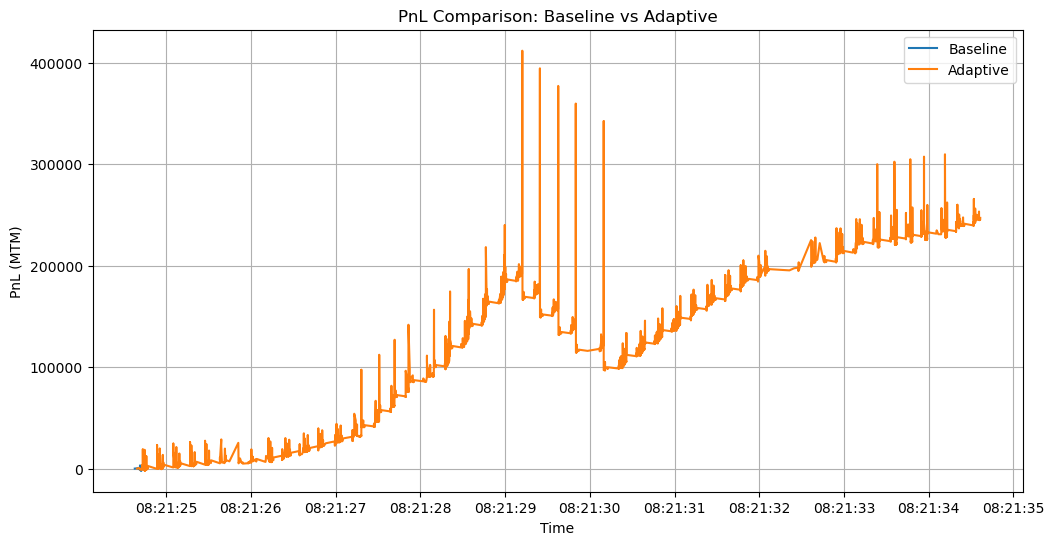

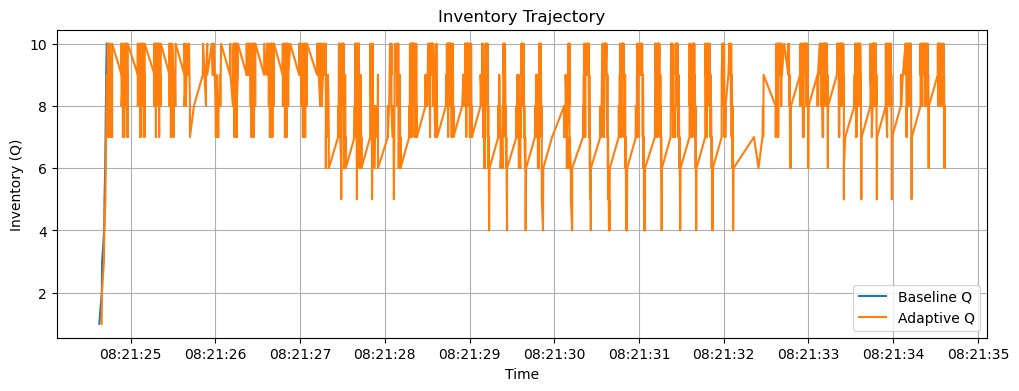

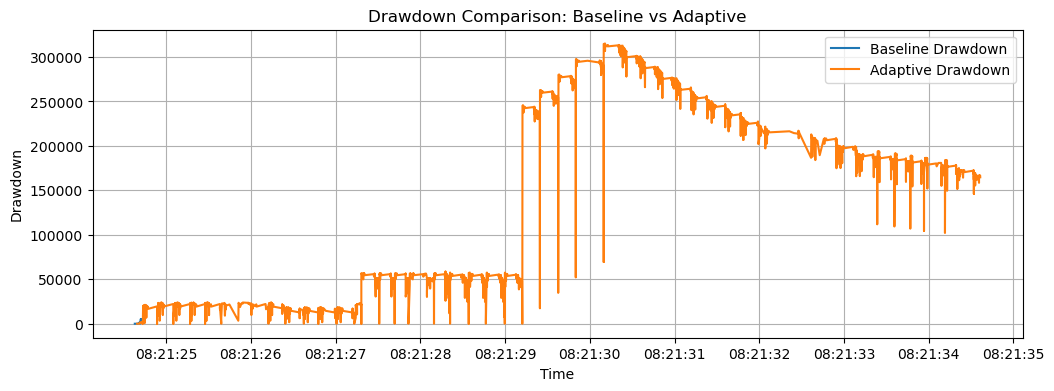

Baseline max drawdown: 5265.0
Adaptive max drawdown: 314902.5
Trade count
Baseline: 10
Adaptive: 2126

Average PnL per trade
Baseline: 176.38888888888889
Adaptive: 116.24352941176471

PnL per unit drawdown (risk-adjusted)
Baseline: 0.3010446343779677
Adaptive: 0.7844173990362097


In [35]:
# Load CSVs
baseline = pd.read_csv("baseline_trades.csv")
adaptive = pd.read_csv("adaptive_trades.csv")

# Compute mid-price
baseline["mid"] = (baseline["best_bid"] + baseline["best_ask"]) / 2
adaptive["mid"] = (adaptive["best_bid"] + adaptive["best_ask"]) / 2

# MTM PnL
baseline["pnl_mtm"] = baseline["cash"] + baseline["Q"] * baseline["mid"]
adaptive["pnl_mtm"] = adaptive["cash"] + adaptive["Q"] * adaptive["mid"]

baseline["time"] = pd.to_datetime(baseline["timestamp"], unit="s")
adaptive["time"] = pd.to_datetime(adaptive["timestamp"], unit="s")

# Plot 1 PnL 
plt.figure(figsize=(12, 6))
plt.plot(baseline["time"], baseline["pnl_mtm"], label="Baseline")
plt.plot(adaptive["time"], adaptive["pnl_mtm"], label="Adaptive")
plt.xlabel("Time")
plt.ylabel("PnL (MTM)")
plt.title("PnL Comparison: Baseline vs Adaptive")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2 Inventory (Q)
plt.figure(figsize=(12, 4))
plt.plot(baseline["time"], baseline["Q"], label="Baseline Q")
plt.plot(adaptive["time"], adaptive["Q"], label="Adaptive Q")
plt.xlabel("Time")
plt.ylabel("Inventory (Q)")
plt.title("Inventory Trajectory")
plt.legend()
plt.grid(True)
plt.show()


# Drawdown calculation
baseline["cummax_pnl"] = baseline["pnl_mtm"].cummax()
baseline["drawdown"] = baseline["cummax_pnl"] - baseline["pnl_mtm"]

adaptive["cummax_pnl"] = adaptive["pnl_mtm"].cummax()
adaptive["drawdown"] = adaptive["cummax_pnl"] - adaptive["pnl_mtm"]

# Plot 3 Drawdown comparison
plt.figure(figsize=(12, 4))
plt.plot(baseline["time"], baseline["drawdown"], label="Baseline Drawdown")
plt.plot(adaptive["time"], adaptive["drawdown"], label="Adaptive Drawdown")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.title("Drawdown Comparison: Baseline vs Adaptive")
plt.legend()
plt.grid(True)
plt.show()

print("Baseline max drawdown:", baseline["drawdown"].max())
print("Adaptive max drawdown:", adaptive["drawdown"].max())

#Trade count
baseline_trades = len(baseline)
adaptive_trades = len(adaptive)

print("Trade count")
print("Baseline:", baseline_trades)
print("Adaptive:", adaptive_trades)
print()


#  Average PnL per trade
baseline_avg_pnl = baseline["pnl_mtm"].diff().mean()
adaptive_avg_pnl = adaptive["pnl_mtm"].diff().mean()

print("Average PnL per trade")
print("Baseline:", baseline_avg_pnl)
print("Adaptive:", adaptive_avg_pnl)
print()


#  Risk-adjusted PnL
#  (Final PnL / Max Drawdown)
baseline_final_pnl = baseline["pnl_mtm"].iloc[-1]
adaptive_final_pnl = adaptive["pnl_mtm"].iloc[-1]

baseline_max_dd = baseline["drawdown"].max()
adaptive_max_dd = adaptive["drawdown"].max()

baseline_risk_adj = (
    baseline_final_pnl / baseline_max_dd
    if baseline_max_dd > 0 else float("inf")
)

adaptive_risk_adj = (
    adaptive_final_pnl / adaptive_max_dd
    if adaptive_max_dd > 0 else float("inf")
)

print("PnL per unit drawdown (risk-adjusted)")
print("Baseline:", baseline_risk_adj)
print("Adaptive:", adaptive_risk_adj)


### VISUALIZATIONS (Afternoon run)
NOTE- Wasn't able to run the code full trading session, due to laptop and electricity constraints

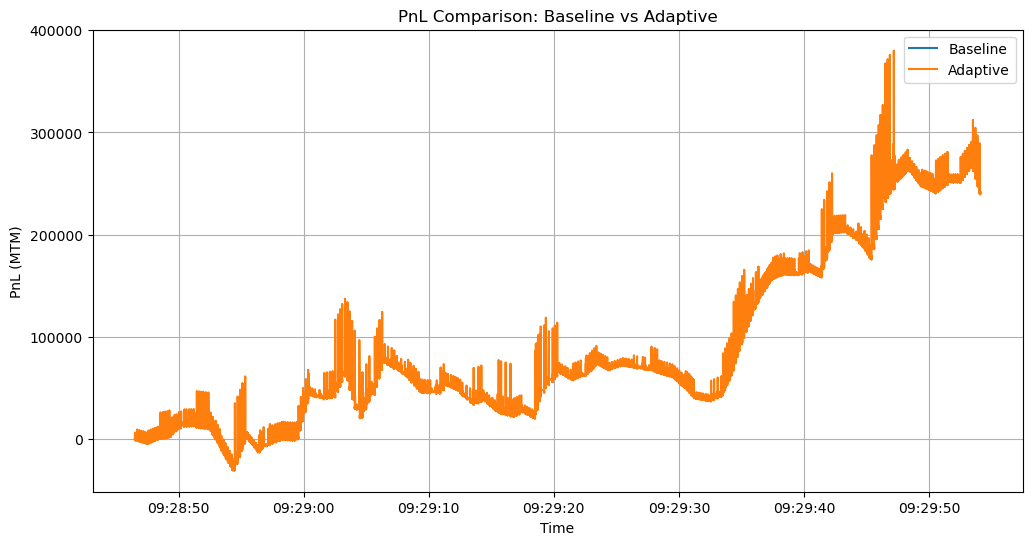

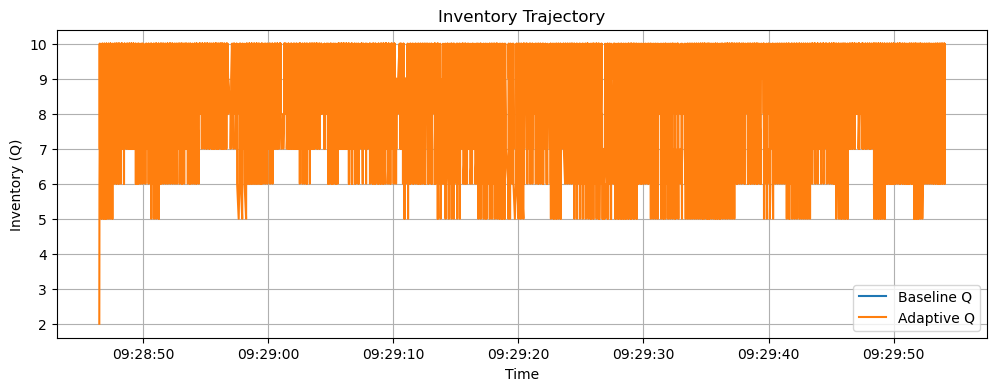

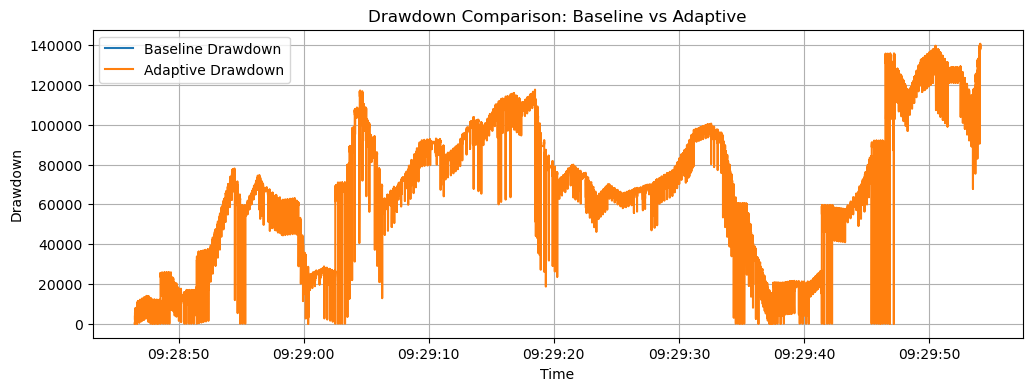

Baseline max drawdown: nan
Adaptive max drawdown: 140750.0
Trade count
Baseline: 0
Adaptive: 12442

Average PnL per trade
Baseline: nan
Adaptive: 19.411823808375534

PnL per unit drawdown (risk-adjusted)
Baseline: inf
Adaptive: 1.7143339253996448


In [34]:
START_ROW = 2175

# Load CSVs
baseline = pd.read_csv("baseline_trades.csv").iloc[START_ROW:].reset_index(drop=True)
adaptive = pd.read_csv("adaptive_trades.csv").iloc[START_ROW:].reset_index(drop=True)


# # Load CSVs
# baseline = pd.read_csv("baseline_trades.csv")
# adaptive = pd.read_csv("adaptive_trades.csv")

# Compute mid-price
baseline["mid"] = (baseline["best_bid"] + baseline["best_ask"]) / 2
adaptive["mid"] = (adaptive["best_bid"] + adaptive["best_ask"]) / 2

# MTM PnL
baseline["pnl_mtm"] = baseline["cash"] + baseline["Q"] * baseline["mid"]
adaptive["pnl_mtm"] = adaptive["cash"] + adaptive["Q"] * adaptive["mid"]

baseline["time"] = pd.to_datetime(baseline["timestamp"], unit="s")
adaptive["time"] = pd.to_datetime(adaptive["timestamp"], unit="s")

# Plot 1 PnL 
plt.figure(figsize=(12, 6))
plt.plot(baseline["time"], baseline["pnl_mtm"], label="Baseline")
plt.plot(adaptive["time"], adaptive["pnl_mtm"], label="Adaptive")
plt.xlabel("Time")
plt.ylabel("PnL (MTM)")
plt.title("PnL Comparison: Baseline vs Adaptive")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2 Inventory (Q)
plt.figure(figsize=(12, 4))
plt.plot(baseline["time"], baseline["Q"], label="Baseline Q")
plt.plot(adaptive["time"], adaptive["Q"], label="Adaptive Q")
plt.xlabel("Time")
plt.ylabel("Inventory (Q)")
plt.title("Inventory Trajectory")
plt.legend()
plt.grid(True)
plt.show()


# Drawdown calculation
baseline["cummax_pnl"] = baseline["pnl_mtm"].cummax()
baseline["drawdown"] = baseline["cummax_pnl"] - baseline["pnl_mtm"]

adaptive["cummax_pnl"] = adaptive["pnl_mtm"].cummax()
adaptive["drawdown"] = adaptive["cummax_pnl"] - adaptive["pnl_mtm"]

# Plot 3 Drawdown comparison
plt.figure(figsize=(12, 4))
plt.plot(baseline["time"], baseline["drawdown"], label="Baseline Drawdown")
plt.plot(adaptive["time"], adaptive["drawdown"], label="Adaptive Drawdown")
plt.xlabel("Time")
plt.ylabel("Drawdown")
plt.title("Drawdown Comparison: Baseline vs Adaptive")
plt.legend()
plt.grid(True)
plt.show()

print("Baseline max drawdown:", baseline["drawdown"].max())
print("Adaptive max drawdown:", adaptive["drawdown"].max())

#Trade count
baseline_trades = len(baseline)
adaptive_trades = len(adaptive)

print("Trade count")
print("Baseline:", baseline_trades)
print("Adaptive:", adaptive_trades)
print()


#  Average PnL per trade
baseline_avg_pnl = baseline["pnl_mtm"].diff().mean()
adaptive_avg_pnl = adaptive["pnl_mtm"].diff().mean()

print("Average PnL per trade")
print("Baseline:", baseline_avg_pnl)
print("Adaptive:", adaptive_avg_pnl)
print()


# #  Risk-adjusted PnL
# #  (Final PnL / Max Drawdown)
# baseline_final_pnl = baseline["pnl_mtm"].iloc[-1]
# adaptive_final_pnl = adaptive["pnl_mtm"].iloc[-1]

baseline_max_dd = baseline["drawdown"].max()
adaptive_max_dd = adaptive["drawdown"].max()

baseline_risk_adj = (
    baseline_final_pnl / baseline_max_dd
    if baseline_max_dd > 0 else float("inf")
)

adaptive_risk_adj = (
    adaptive_final_pnl / adaptive_max_dd
    if adaptive_max_dd > 0 else float("inf")
)

print("PnL per unit drawdown (risk-adjusted)")
print("Baseline:", baseline_risk_adj)
print("Adaptive:", adaptive_risk_adj)


### ALPHA AND K PARAMETER SELECTOR (TO BE MADE)

In [37]:
import pandas as pd
import numpy as np

# Load your adaptive trade CSV (or any snapshot CSV)
df = pd.read_csv("adaptive_trades.csv")

# Keep only market info
df = df[["best_bid", "best_ask"]].dropna().reset_index(drop=True)

# Mid price
df["mid"] = (df["best_bid"] + df["best_ask"]) / 2


In [47]:
def backtest_adaptive(
    df,
    alpha,
    k,
    s0=10,
    Qmax=10,
    tick_size=5,
    relax_ticks=1
):
    Q = 0
    cash = 0.0

    pnl_series = []
    trade_count = 0

    RELAX_EPS = relax_ticks * tick_size

    prev_mid = df.loc[0, "mid"]

    for _, row in df.iterrows():
        bt = row["best_bid"]
        at = row["best_ask"]
        mt = row["mid"]

        # Price-pressure imbalance proxy
        I_t = np.sign(mt - prev_mid)

        st = s0 * (1 + alpha * abs(I_t))

        b_hat = mt - st / 2 - k * Q
        a_hat = mt + st / 2 - k * Q

        # BUY (relaxed)
        if b_hat >= at - RELAX_EPS and Q < Qmax:
            Q += 1
            cash -= at
            trade_count += 1

        # SELL (relaxed)
        elif a_hat <= bt + RELAX_EPS and Q > -Qmax:
            Q -= 1
            cash += bt
            trade_count += 1

        pnl_series.append(cash + Q * mt)
        prev_mid = mt

    pnl_series = np.array(pnl_series)

    final_pnl = pnl_series[-1]
    max_dd = np.max(np.maximum.accumulate(pnl_series) - pnl_series)

    return {
        "final_pnl": final_pnl,
        "max_drawdown": max_dd,
        "trade_count": trade_count
    }


In [63]:
# Alpha: moderate resolution
alpha_grid = np.linspace(0.1, 1.0, 9)   # step ≈ 0.1

# k: fewer, meaningful values
k_grid = np.concatenate([
    np.linspace(-0.05, 0.0, 3),          # mild momentum
    np.linspace(0.05, 0.25, 7)            # inventory control
])

alphas = alpha_grid
ks = k_grid

print("Total combinations:", len(alphas) * len(ks))

results = []

LAMBDA_DD = 0.1
MU_TRADES = 0.06

for alpha in alphas:
    for k in ks:
        stats = backtest_adaptive(df, alpha, k)

        score = (
            stats["final_pnl"]
            - LAMBDA_DD * stats["max_drawdown"]
            + MU_TRADES * stats["trade_count"]
        )

        results.append({
            "alpha": alpha,
            "k": k,
            "final_pnl": stats["final_pnl"],
            "max_drawdown": stats["max_drawdown"],
            "trade_count": stats["trade_count"],
            "score": score
        })

results_df = pd.DataFrame(results)
results_df.sort_values("score", ascending=False).head(10)



Total combinations: 90


,alpha,k,final_pnl,max_drawdown,trade_count,score
0,0.1000,-0.050000,0.0,0.0,0,0.0
67,0.7750,0.183333,0.0,0.0,0,0.0
65,0.7750,0.116667,0.0,0.0,0,0.0
64,0.7750,0.083333,0.0,0.0,0,0.0
63,0.7750,0.050000,0.0,0.0,0,0.0
62,0.7750,0.000000,0.0,0.0,0,0.0
61,0.7750,-0.025000,0.0,0.0,0,0.0
60,0.7750,-0.050000,0.0,0.0,0,0.0
59,0.6625,0.250000,0.0,0.0,0,0.0
58,0.6625,0.216667,0.0,0.0,0,0.0


In [ ]:
results_df.sort_values("score", ascending=False).head(5)


In [65]:
best = results_df.loc[results_df["score"].idxmax()]
best


alpha           0.10
k              -0.05
final_pnl       0.00
max_drawdown    0.00
trade_count     0.00
score           0.00
Name: 0, dtype: float64